<a href="https://colab.research.google.com/github/carlos-argueta/rse_prob_robotics/blob/main/rse_perception_experiments/notebooks/Simple_Robotics_Perception_Experiment_2_Fine_Tunning_Yolo_v8_with_SAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simple Robotics Perception Experiments - Fine-Tuning Yolo v8 with SAM 2

## Setup

In [ ]:
!pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
time: 405 µs (started: 2024-12-18 10:09:23 +00:00)


In [ ]:
!pip3 install ultralytics autodistill-grounded-sam roboflow autodistill_florence_2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.5 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn
  Atte

In [ ]:
!git clone https://github.com/autodistill/autodistill-grounded-sam-2.git

Cloning into 'autodistill-grounded-sam-2'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 98 (delta 46), reused 68 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 24.73 KiB | 8.24 MiB/s, done.
Resolving deltas: 100% (46/46), done.
time: 810 ms (started: 2024-12-18 10:10:01 +00:00)


## Download dataset

In [ ]:
!wget https://www.dropbox.com/scl/fi/js48wtvykxewotsx4hqis/shl1-input_dataset.zip?rlkey=s24tewcmak5xsniwz7mh6hfr8&st=domup9c3&dl=0
!mv shl1-input_dataset.zip?rlkey=s24tewcmak5xsniwz7mh6hfr8 shl1-input_dataset.zip
!unzip shl1-input_dataset.zip

--2024-12-18 10:10:02--  https://www.dropbox.com/scl/fi/js48wtvykxewotsx4hqis/shl1-input_dataset.zip?rlkey=s24tewcmak5xsniwz7mh6hfr8
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8554158c75437cb1986972078d.dl.dropboxusercontent.com/cd/0/inline/CgfUpOzOdgek9JH9Hm3qAD5SDPTnV4xTNpNQWi4gl3iV-nLyVTGPh-wFzKQ6ChCEx_AA39ozkoQFH5UN8y0WcjtuLK-vH39LlQ9zEVDjpvvlaulYtf8rGQmozwaR6GRS6uI/file# [following]
--2024-12-18 10:10:02--  https://uc8554158c75437cb1986972078d.dl.dropboxusercontent.com/cd/0/inline/CgfUpOzOdgek9JH9Hm3qAD5SDPTnV4xTNpNQWi4gl3iV-nLyVTGPh-wFzKQ6ChCEx_AA39ozkoQFH5UN8y0WcjtuLK-vH39LlQ9zEVDjpvvlaulYtf8rGQmozwaR6GRS6uI/file
Resolving uc8554158c75437cb1986972078d.dl.dropboxusercontent.com (uc8554158c75437cb1986972078d.dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6017:15::a27d:20f
Connecting

## Imports

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

import os
import sys
sys.path.append('/content/autodistill-grounded-sam-2')

import torch
import gc

from autodistill_grounded_sam_2 import GroundedSAM2
from autodistill.detection import CaptionOntology
from autodistill.utils import plot

from ultralytics import YOLO

import matplotlib.pyplot as plt

import cv2

Importing from timm.models.layers is deprecated, please import via timm.layers


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
time: 4min 51s (started: 2024-12-18 10:10:40 +00:00)


## Setup ontology and base Grounded SAM 2 model

In [ ]:
# define an ontology to map class names to our Grounded SAM 2 prompt
# the ontology dictionary has the format {caption: class}
# where caption is the prompt sent to the base model, and class is the label that will
# be saved for that caption in the generated annotations
# then, load the model
ontology = CaptionOntology(
        {
            "6-wheeled robot with mounted LiDAR.": "SHL-1",
        }
    )

base_model = GroundedSAM2(ontology=ontology, model = "Grounding DINO")


trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

time: 16 s (started: 2024-12-18 10:15:32 +00:00)


## Test the base model on a single image

In [ ]:
# run inference on a single image
results = base_model.predict("/content/input_dataset/image_00011.png")

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


time: 7.35 s (started: 2024-12-18 10:15:48 +00:00)


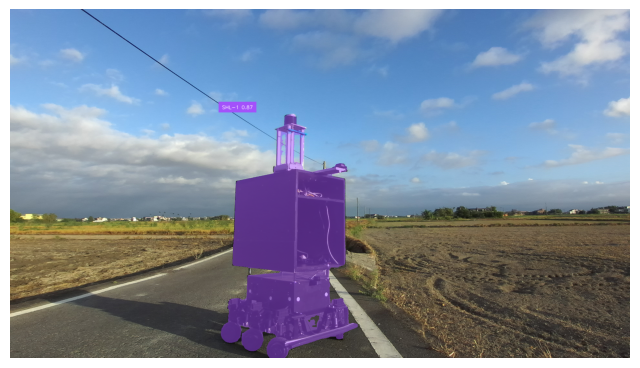

time: 907 ms (started: 2024-12-18 10:15:55 +00:00)


In [ ]:
plot(
    image=cv2.imread("/content/input_dataset/image_00011.png"),
    classes=base_model.ontology.classes(),
    detections=results
)

## Use the base Grounded SAM 2 model to annotate a dataset of SHL-1 images

In [ ]:
# label all images in a folder called `input_dataset`
dataset = base_model.label("/content/input_dataset", extension=".png", output_folder="dataset")

Labeling /content/input_dataset/image_00060.png: 100%|██████████| 420/420 [07:40<00:00,  1.10s/it]


Labeled dataset created - ready for distillation.
time: 9min (started: 2024-12-18 10:15:56 +00:00)


## Fine-tune a YOLO v8 model with the dataset

### Fine-tune a nano model

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a model
target_model_n = YOLO('yolov8n-seg.pt')  # load a pretrained model
target_model_n.train(data="dataset/data.yaml", epochs=200, device=0)

100%|██████████| 6.74M/6.74M [00:00<00:00, 117MB/s]

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=dataset/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dyn

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 336 images, 0 backgrounds, 0 corrupt: 100%|██████████| 336/336 [00:00<00:00, 915.28it/s]

train: WARNING ⚠️ /content/dataset/train/images/image_00204.jpg: 1 duplicate labels removed
train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/dataset/valid/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 645.48it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.45G     0.9177      2.233      1.858      1.217         48        640: 100%|██████████| 21/21 [00:15<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         84         91          1      0.863      0.948      0.731          1      0.863      0.925      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.95G     0.7211      1.468      1.097      1.049         38        640: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         84         91          1     0.0899      0.462      0.325          1     0.0899      0.386      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.92G     0.7471      1.291     0.9904      1.063         53        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         84         91      0.868       0.58      0.703      0.474      0.818      0.319      0.311      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.94G     0.7662      1.492      0.903      1.069         38        640: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         84         91      0.683       0.89      0.805      0.633      0.658      0.857      0.739      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.96G     0.7642      1.469     0.8465       1.05         48        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         84         91      0.837      0.923      0.882       0.62      0.837      0.923      0.881      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.94G     0.7464      1.411     0.8307      1.037         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all         84         91      0.953      0.891      0.941      0.695      0.816      0.684      0.686      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.94G     0.7213       1.44     0.7744      1.037         49        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         84         91      0.956      0.944      0.945      0.739       0.63      0.626      0.402       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.94G     0.6845        1.2     0.7272      1.023         54        640: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.983      0.923      0.963      0.753      0.983      0.923      0.935      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.92G     0.6667      1.267     0.6413      1.008         35        640: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         84         91      0.996      0.923      0.931      0.785      0.986      0.912      0.917      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.92G      0.691      1.278     0.6569      1.022         48        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         84         91      0.953      0.886      0.937      0.708      0.953      0.886      0.932      0.653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.92G     0.6878      1.303     0.6098      1.035         49        640: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         84         91          1      0.932      0.955      0.772      0.996      0.923      0.928      0.757



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.92G     0.6721      1.185     0.5999      1.019         41        640: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         84         91          1      0.932      0.969      0.832          1      0.932      0.944      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.94G     0.6655      1.146     0.5441      1.014         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         84         91      0.993      0.923      0.973      0.838      0.874      0.813      0.835      0.697



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.92G     0.6817      1.333     0.5537      1.041         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.998      0.934      0.983      0.818      0.998      0.912      0.943      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.94G     0.6342      1.208     0.5284      1.016         47        640: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         84         91      0.998      0.945      0.969      0.806      0.989      0.912       0.94      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.95G     0.6798      1.264     0.5482      1.026         44        640: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all         84         91      0.993      0.934      0.957      0.812      0.987      0.923      0.934      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.92G     0.6485      1.238     0.5415      1.001         48        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         84         91      0.999      0.945      0.972      0.811      0.794      0.747      0.731       0.58



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.92G     0.6538      1.244     0.5035      1.019         49        640: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         84         91      0.966       0.94      0.974      0.759      0.863      0.835      0.856      0.696



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.97G     0.6016      1.334     0.4751     0.9935         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         84         91      0.998      0.923      0.931      0.775      0.998      0.923       0.93      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.92G     0.6207      1.234     0.4732     0.9957         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.998      0.923      0.938      0.766      0.998      0.923      0.936      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.97G      0.636      1.343     0.4841      1.002         49        640: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.998      0.934      0.956      0.795      0.988      0.923       0.94      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.92G     0.6371      1.154      0.485      1.009         46        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.983      0.923      0.946      0.816      0.986      0.923      0.934      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200       3.9G     0.6183      1.148     0.4535     0.9977         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         84         91      0.987      0.923      0.944      0.803      0.968      0.857      0.891      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.94G     0.5869      1.001     0.4388     0.9712         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.999      0.923      0.967      0.862      0.975      0.901      0.912      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200       3.9G     0.5895      1.139     0.4703     0.9895         35        640: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.998      0.923      0.956      0.846      0.987      0.912      0.939      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.92G     0.5895       1.13     0.4574     0.9983         37        640: 100%|██████████| 21/21 [00:12<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all         84         91          1      0.933      0.961      0.781          1      0.933       0.95      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.92G     0.5531        1.1     0.4332     0.9607         42        640: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         84         91      0.991      0.923      0.978      0.871      0.991      0.923      0.949      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.92G     0.5531      1.271     0.4401     0.9755         40        640: 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         84         91      0.988      0.923       0.97      0.859      0.988      0.923      0.946      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.89G     0.5408      1.198     0.4213      0.988         43        640: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         84         91      0.955      0.941       0.95      0.857      0.944       0.93      0.933      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.92G     0.5526      1.156     0.4328     0.9956         34        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         84         91      0.999      0.923      0.947      0.878      0.999      0.923      0.947      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.94G     0.5717       1.06     0.4144     0.9887         41        640: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         84         91      0.996      0.923       0.96      0.854      0.996      0.923      0.945      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.92G     0.5417      1.024     0.4046     0.9728         45        640: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.998      0.923      0.952      0.863      0.998      0.923      0.946      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.88G      0.564     0.9655     0.3956     0.9852         46        640: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         84         91      0.999      0.923      0.943      0.843      0.999      0.923      0.943      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.96G     0.5498      1.059     0.4146     0.9763         40        640: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.994      0.923      0.955      0.848      0.994      0.923      0.947      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.94G     0.5529      1.087     0.4133     0.9837         44        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         84         91      0.999      0.923      0.958      0.857      0.999      0.923      0.949      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.95G     0.5287       1.14     0.4011     0.9717         39        640: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.999      0.923      0.957      0.869      0.999      0.923      0.949      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.93G      0.497      1.079     0.3842     0.9608         44        640: 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         84         91      0.999      0.923      0.975      0.867      0.999      0.923       0.95      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200       3.9G     0.5237      1.059     0.3942     0.9694         44        640: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         84         91      0.999      0.923      0.966      0.863      0.975      0.901      0.935      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.94G     0.5098     0.9803     0.4004     0.9687         34        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         84         91      0.988       0.94      0.964      0.864      0.977      0.929      0.938      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.92G     0.5126      1.046     0.3825     0.9661         35        640: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all         84         91          1      0.933      0.983      0.857      0.988      0.912      0.945       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.92G     0.5188      1.044     0.3935     0.9617         35        640: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         84         91      0.999      0.923      0.956      0.862      0.965      0.868      0.928      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.92G     0.5301      1.022     0.3826     0.9699         43        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         84         91      0.999      0.923       0.96      0.876      0.947      0.857      0.876      0.796



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.92G     0.5272      1.011     0.3749     0.9761         49        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.996      0.923      0.948      0.872      0.913      0.846      0.818       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.94G      0.547      1.037     0.3894     0.9801         39        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         84         91      0.999      0.923      0.948      0.841      0.858      0.791      0.764      0.688



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.97G     0.4958      1.049     0.3804     0.9576         39        640: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         84         91      0.999      0.923       0.95       0.88      0.947      0.846      0.886      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200       3.9G      0.494     0.9962     0.3609     0.9545         34        640: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         84         91      0.999      0.923      0.953      0.879      0.999      0.923      0.949      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.95G     0.5289      1.136     0.3866     0.9618         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all         84         91      0.999      0.923      0.958       0.87      0.975      0.901      0.938      0.862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.92G     0.5132      1.028     0.3791     0.9612         40        640: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.999      0.923      0.958      0.883      0.999      0.923      0.949      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.89G      0.499      1.037     0.3826     0.9595         35        640: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         84         91      0.999      0.934      0.971      0.895      0.953        0.9      0.928      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.94G     0.4926      1.035     0.3602     0.9603         45        640: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91      0.999      0.923      0.969       0.88      0.987      0.912      0.948      0.874



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.92G     0.4861      1.041     0.3625     0.9392         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         84         91      0.999      0.923       0.96      0.882       0.94      0.835      0.922       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.92G     0.5026      1.067     0.3541     0.9633         37        640: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         84         91      0.999      0.923      0.947      0.863      0.999      0.923      0.947      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.94G     0.5016      1.061     0.3757     0.9595         49        640: 100%|██████████| 21/21 [00:10<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         84         91      0.999      0.923      0.939      0.862      0.999      0.923      0.936      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.92G     0.4951      1.088     0.3601     0.9685         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.934      0.969       0.89      0.996      0.923      0.952      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.94G     0.4747      1.025     0.3458      0.955         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         84         91      0.999      0.934      0.965        0.9      0.996      0.923      0.947      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.92G     0.5046     0.9654     0.3615     0.9568         52        640: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         84         91      0.999      0.923      0.949       0.89      0.977      0.901      0.929      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.92G     0.4986      0.934     0.3605     0.9564         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         84         91      0.999      0.923      0.966      0.882      0.928      0.857      0.908      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.89G     0.4498     0.9682     0.3402     0.9441         35        640: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.999      0.923      0.955       0.86      0.952      0.879      0.928      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.92G     0.5161     0.9977     0.3561     0.9556         34        640: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         84         91      0.999      0.923      0.979      0.878      0.952      0.879      0.937      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.91G     0.4707     0.9809     0.3508     0.9477         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.999      0.923      0.966      0.885      0.928      0.857      0.912      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.92G     0.5096      1.031     0.3638     0.9607         36        640: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         84         91      0.999      0.923      0.949      0.872      0.894      0.835      0.858      0.772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.93G     0.4932      1.082     0.3724     0.9681         40        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         84         91      0.999      0.923      0.948       0.89      0.835      0.779      0.863      0.745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.92G      0.453     0.9908     0.3379     0.9329         48        640: 100%|██████████| 21/21 [00:10<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         84         91      0.999      0.923      0.953      0.892      0.953      0.889      0.946      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.92G     0.4516      1.037     0.3334     0.9438         52        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         84         91          1      0.939      0.957      0.899          1      0.939      0.957      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.89G     0.4533      1.016     0.3199     0.9498         54        640: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         84         91          1      0.945      0.954      0.887          1      0.945      0.954       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.93G     0.4617     0.9139     0.3361     0.9527         51        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         84         91          1      0.933      0.951       0.89      0.953      0.889      0.913      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.92G     0.4762     0.9921     0.3449     0.9473         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         84         91          1      0.933      0.949      0.896      0.953       0.89      0.902      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.89G      0.439     0.9004     0.3275     0.9313         40        640: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         84         91          1      0.933      0.963      0.912      0.941      0.878      0.911      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.91G     0.4976     0.8747     0.3626     0.9633         37        640: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.988      0.934      0.954      0.887      0.947      0.824      0.875      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.89G     0.4975     0.9996     0.3588     0.9765         41        640: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         84         91      0.999      0.923      0.951      0.883      0.952      0.846      0.875      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.92G     0.4597     0.9215     0.3282     0.9428         48        640: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         84         91      0.999      0.923      0.952      0.899      0.987      0.912      0.941      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.94G     0.4604      1.015     0.3282     0.9569         45        640: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         84         91          1      0.933      0.952      0.854      0.953      0.889      0.911      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.95G     0.4865     0.9956     0.3356     0.9496         47        640: 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         84         91      0.988      0.939       0.95      0.895      0.977      0.928      0.938      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.91G     0.4619     0.8982      0.325     0.9549         44        640: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         84         91      0.999      0.923      0.949      0.889      0.905      0.835      0.862      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200       3.9G     0.4346      0.828     0.3113     0.9331         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.988      0.932      0.952      0.896      0.881      0.813      0.881      0.792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200         4G     0.4485     0.8646     0.3219     0.9581         40        640: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         84         91          1      0.934      0.982      0.908      0.953      0.846      0.931      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.95G     0.4509     0.9186     0.3275     0.9554         44        640: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

                   all         84         91       0.98      0.934      0.986      0.912      0.912      0.813      0.907      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.95G     0.4272     0.9992     0.3214     0.9271         45        640: 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         84         91      0.977      0.953      0.988      0.897      0.932      0.909      0.949      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.89G     0.4472      0.809     0.3374     0.9425         36        640: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         84         91      0.999      0.923      0.974      0.889      0.952      0.879       0.93      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.89G     0.4165     0.9827     0.3117     0.9293         43        640: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         84         91          1      0.933      0.967      0.895      0.949      0.835      0.886       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200       3.9G     0.4354     0.8971     0.3118     0.9449         47        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         84         91      0.999      0.923      0.966      0.883      0.973      0.835       0.91      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200       3.9G     0.4675      1.095     0.3339     0.9605         43        640: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         84         91      0.999      0.923      0.961      0.886      0.951      0.868      0.923      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.94G     0.4321     0.9076     0.3172     0.9318         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         84         91          1      0.933      0.962      0.889      0.979      0.879      0.937      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200       3.9G     0.4177     0.8309      0.309     0.9281         48        640: 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         84         91      0.999      0.923      0.964      0.916      0.954      0.909      0.953      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.92G     0.4373     0.9382     0.3298     0.9317         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         84         91      0.999      0.923       0.97      0.915      0.941      0.846      0.926      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200       3.9G     0.4351     0.8518     0.3194     0.9364         40        640: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.988      0.938      0.977        0.9      0.954      0.909      0.949      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.92G     0.4369     0.8572     0.3279     0.9326         39        640: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all         84         91      0.983      0.945      0.953      0.895      0.983      0.945      0.953      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200       3.9G     0.4265     0.9007     0.3143     0.9308         42        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         84         91      0.987      0.945      0.956      0.898      0.987      0.945      0.956      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.94G     0.4398      0.885     0.3251     0.9462         50        640: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         84         91      0.999      0.923       0.95      0.874      0.999      0.923       0.95      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.92G     0.4226     0.8159     0.3151     0.9435         42        640: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         84         91      0.988      0.933      0.953      0.875      0.988      0.933      0.951      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200       3.9G       0.43       0.81     0.3101     0.9281         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.985      0.923      0.954      0.884      0.985      0.923      0.948      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200       3.9G     0.4149     0.8832      0.298     0.9299         46        640: 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         84         91      0.999      0.923      0.952      0.892      0.999      0.923      0.952        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200       3.9G     0.4054     0.8446     0.3039     0.9345         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         84         91      0.988      0.932       0.95      0.894      0.988      0.932       0.95      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.94G     0.4175      0.909     0.3046     0.9374         36        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all         84         91      0.999      0.923      0.956      0.913      0.978      0.901      0.935      0.873



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.92G     0.4361      0.903     0.3238     0.9357         39        640: 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         84         91      0.999      0.923      0.957      0.897      0.999      0.923      0.948      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200       3.9G     0.4211     0.8984     0.3109     0.9365         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         84         91      0.999      0.923       0.98      0.926      0.999      0.923      0.954      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200       3.9G     0.4369     0.8562     0.3206     0.9358         40        640: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         84         91      0.998      0.934      0.984      0.925      0.998      0.934      0.956      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.92G      0.425     0.8492     0.3015     0.9245         50        640: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91          1      0.933      0.987      0.919          1      0.933      0.958      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.89G     0.3755     0.9409      0.282     0.9112         46        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91          1      0.933      0.991      0.922      0.976      0.911      0.933      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.94G     0.4321      0.776     0.3125     0.9572         39        640: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all         84         91      0.999      0.923      0.963      0.893      0.952      0.879      0.895      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200       3.9G      0.427     0.9367     0.3018     0.9415         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         84         91      0.999      0.923      0.962      0.895      0.908      0.872      0.879      0.808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.94G     0.4099     0.9595     0.3079     0.9352         44        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         84         91      0.999      0.923      0.959      0.899      0.928      0.901      0.899      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200       3.9G     0.3981     0.8803     0.2801     0.9133         41        640: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         84         91      0.999      0.923      0.969      0.901      0.951      0.879      0.913       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.95G     0.4165     0.9097     0.3014     0.9313         39        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         84         91      0.999      0.923       0.97      0.916      0.999      0.923       0.95      0.898



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.92G     0.4168     0.8835        0.3     0.9302         43        640: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         84         91      0.999      0.923      0.971      0.918      0.999      0.923      0.953      0.888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.92G     0.3899     0.8405     0.2958     0.9155         49        640: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         84         91          1      0.932      0.963      0.884      0.987      0.912      0.938      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200       3.9G     0.4039     0.8254     0.3068     0.9287         34        640: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         84         91      0.943      0.923      0.937      0.856      0.921      0.901      0.893      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200       3.9G      0.433     0.8805      0.307      0.944         37        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         84         91      0.988      0.923      0.972      0.924      0.952       0.89      0.919      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.92G     0.3938     0.8891     0.2899     0.9149         26        640: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         84         91      0.999      0.923      0.965      0.914      0.928      0.857       0.88      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.89G     0.4133     0.8505     0.3123     0.9361         35        640: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         84         91          1      0.923      0.963        0.9      0.928      0.857      0.891      0.799



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.94G     0.4035     0.7974     0.2901     0.9351         37        640: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         84         91      0.999      0.923      0.969      0.916      0.951      0.879      0.933      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.92G     0.4275     0.8879     0.3106     0.9414         41        640: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         84         91          1      0.933      0.966      0.919      0.928       0.89       0.91      0.852



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.94G      0.393     0.8117     0.2966     0.9252         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         84         91      0.995      0.945      0.962       0.92      0.949      0.901       0.92      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.92G     0.3787     0.7736     0.2836     0.9155         40        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         84         91          1      0.933      0.979      0.927      0.954      0.868      0.933      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.92G     0.3861     0.8345      0.295     0.9344         39        640: 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         84         91      0.978      0.976      0.989      0.934      0.901      0.899      0.929      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200       3.9G     0.4169     0.8047     0.3002     0.9563         35        640: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         84         91      0.987      0.945      0.959      0.925      0.918      0.879      0.887      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.89G     0.3735     0.6647     0.2706     0.9218         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         84         91      0.999      0.923      0.963      0.912      0.918      0.861      0.874      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200       3.9G     0.3962     0.8707     0.2965     0.9359         50        640: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         84         91          1      0.934      0.985      0.921      0.884      0.879      0.875      0.789



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.92G       0.39     0.7119     0.2957     0.9311         38        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         84         91      0.995      0.945       0.96      0.913      0.926      0.879      0.879      0.792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.92G     0.3953     0.8408     0.2837     0.9329         31        640: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         84         91      0.988      0.945      0.974      0.926      0.907      0.868      0.917      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.95G     0.3724     0.8671     0.2753     0.9062         42        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         84         91      0.988      0.945      0.971       0.93       0.93       0.89      0.926      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.94G     0.3809     0.7615     0.2698     0.9151         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         84         91      0.984      0.945      0.964      0.926      0.904      0.868       0.89      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.92G     0.3774     0.7383     0.2721     0.9227         45        640: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all         84         91          1      0.933      0.987      0.902          1      0.933      0.968      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.89G     0.3959     0.7804     0.2882     0.9342         38        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         84         91      0.988      0.942      0.982      0.928      0.988      0.942      0.965      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.91G     0.3981       0.78     0.2916     0.9271         43        640: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.982      0.945      0.973      0.918      0.982      0.945      0.962      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200       3.9G     0.3939     0.7879     0.2893     0.9358         45        640: 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         84         91          1      0.939      0.968       0.91      0.965      0.908      0.942       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.92G     0.3728     0.7956     0.2766     0.9152         34        640: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         84         91      0.996      0.945      0.961      0.898      0.938       0.89      0.924      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.92G     0.4027     0.8132     0.2946     0.9413         38        640: 100%|██████████| 21/21 [00:10<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         84         91      0.994      0.945      0.969      0.918      0.983      0.934      0.951      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200       3.9G      0.379     0.8312     0.2821     0.9073         47        640: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         84         91          1      0.942      0.988      0.938          1      0.942      0.961      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.92G     0.3858     0.7428     0.2818     0.9263         44        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         84         91          1      0.942      0.987       0.93          1      0.942      0.963      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.96G     0.3876     0.8252     0.2817     0.9196         39        640: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         84         91          1      0.933      0.961      0.917      0.965        0.9      0.935      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200       3.9G     0.3857     0.8072     0.2943     0.9221         36        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         84         91      0.999      0.923      0.966      0.924      0.916      0.846      0.904      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.92G     0.4012     0.7118     0.2943      0.938         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         84         91      0.999      0.923      0.964      0.927      0.911      0.824      0.901      0.858



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.92G     0.3762     0.8358     0.2762      0.917         42        640: 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         84         91      0.999      0.923      0.965      0.925      0.947      0.846      0.922      0.867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.89G     0.3902     0.7316     0.2842     0.9238         45        640: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         84         91          1      0.933      0.975       0.92      0.929      0.867      0.919      0.853



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.94G     0.3976     0.7639     0.2913     0.9284         46        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         84         91          1      0.933      0.981      0.921      0.921      0.899      0.943      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.92G     0.3429     0.8177     0.2636     0.9089         48        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         84         91          1      0.933      0.987       0.93      0.863       0.89      0.934       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.92G     0.3751     0.7873     0.2679     0.9239         49        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         84         91      0.995      0.945      0.974      0.929      0.937       0.89      0.944      0.871



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.95G     0.3619     0.6548     0.2642     0.9095         44        640: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         84         91      0.988      0.942      0.968      0.927      0.954       0.91      0.932      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.92G     0.3718     0.7411     0.2732     0.9297         48        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         84         91      0.999      0.923      0.962      0.925      0.999      0.923      0.962      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.91G     0.3191     0.7758     0.2533     0.8854         44        640: 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         84         91      0.994      0.923      0.964      0.913      0.994      0.923       0.96      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.92G     0.3709     0.7043      0.272     0.9219         47        640: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         84         91      0.999      0.923      0.962      0.913      0.999      0.923      0.955      0.907



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.95G     0.3812     0.7959     0.2744     0.9133         39        640: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91      0.999      0.956      0.972      0.929      0.999      0.923      0.948      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.92G     0.3466     0.7093      0.267     0.9024         41        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.999      0.923      0.979      0.928      0.999      0.923      0.957       0.91



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200       3.9G     0.3486     0.7274     0.2705     0.8936         42        640: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         84         91      0.999      0.923      0.974      0.924      0.963       0.89      0.929      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.96G     0.3612     0.7258     0.2721     0.9202         47        640: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         84         91      0.999      0.923      0.959      0.916      0.975      0.901      0.939      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.88G      0.351     0.7459     0.2647     0.9077         47        640: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         84         91          1       0.94      0.971      0.936      0.953      0.898      0.946       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.87G     0.3398      0.752     0.2538     0.9056         45        640: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         84         91      0.999      0.945      0.982      0.934      0.927      0.879      0.937      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.89G     0.3615     0.7249     0.2559      0.927         44        640: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         84         91          1      0.937       0.97       0.94      0.953      0.898      0.935      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.92G      0.368     0.7116     0.2592     0.9266         40        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91          1       0.94      0.965      0.932      0.953      0.897      0.939      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      3.92G     0.3608      0.685     0.2607     0.9133         40        640: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         84         91          1      0.933      0.967      0.923      0.953      0.889      0.954        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.91G     0.3538     0.6483     0.2562     0.9187         42        640: 100%|██████████| 21/21 [00:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         84         91      0.999      0.923       0.98      0.917      0.963       0.89      0.956      0.903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.92G     0.3359     0.6591     0.2618     0.9001         40        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         84         91      0.989      0.945      0.971      0.921      0.966      0.923      0.941        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.95G       0.35     0.7018      0.261     0.9159         39        640: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         84         91      0.987      0.945      0.972      0.918      0.952      0.912      0.931      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.89G     0.3517     0.6501     0.2632     0.9135         47        640: 100%|██████████| 21/21 [00:10<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         84         91      0.984      0.945      0.971      0.925      0.961      0.923      0.938      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.92G     0.3441     0.6095     0.2557     0.9067         49        640: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.978      0.958       0.98      0.931      0.963       0.89      0.931      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.94G     0.3348     0.6811     0.2646     0.8997         46        640: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.965      0.978      0.981      0.935      0.975      0.901      0.946      0.892



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.89G     0.3349     0.6732     0.2608     0.9097         40        640: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         84         91      0.961      0.978      0.981      0.937      0.975      0.901      0.949      0.893



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.96G     0.3289     0.5847     0.2452     0.8939         36        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         84         91          1      0.955       0.99      0.936      0.975      0.901      0.962      0.896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.92G     0.3442     0.6976      0.264     0.9144         33        640: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         84         91      0.999      0.923      0.973      0.937      0.987      0.912      0.958      0.909



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.92G      0.357     0.7461     0.2588     0.9137         38        640: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         84         91      0.976      0.945       0.96      0.926      0.942      0.912      0.932      0.887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.93G      0.367     0.6611     0.2676     0.9258         38        640: 100%|██████████| 21/21 [00:11<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         84         91       0.98      0.945      0.971      0.935      0.945      0.912       0.95      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.88G     0.3652     0.7266     0.2627      0.927         33        640: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         84         91      0.999      0.923      0.969      0.937      0.931      0.901      0.945      0.878



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.89G      0.349     0.6791     0.2459     0.9123         51        640: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         84         91          1      0.933      0.982       0.94      0.965        0.9      0.956       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.92G       0.32     0.7608     0.2502     0.9026         39        640: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         84         91          1      0.945      0.984      0.939      0.953      0.901      0.943       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200       3.9G     0.3396     0.6516     0.2462      0.923         44        640: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         84         91          1      0.944      0.987      0.938      0.953        0.9      0.948      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.93G      0.322       0.59     0.2437     0.9019         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         84         91          1      0.942      0.989      0.944      0.918      0.865      0.928      0.845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.89G     0.3113     0.6479     0.2293     0.8842         43        640: 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         84         91          1      0.943      0.973      0.941      0.918      0.866      0.922      0.855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.91G     0.3162     0.7096      0.232     0.8863         34        640: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         84         91      0.999      0.923      0.962      0.925       0.94      0.868      0.934      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.92G     0.3104     0.6429     0.2321     0.8927         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         84         91      0.999      0.923      0.969      0.924      0.964       0.89      0.952      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.92G     0.3395     0.6996     0.2521        0.9         46        640: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         84         91      0.999      0.923      0.957      0.925      0.976      0.901      0.943      0.905



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.91G     0.3226     0.6206     0.2425     0.9107         35        640: 100%|██████████| 21/21 [00:10<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         84         91      0.976      0.945      0.966      0.934      0.965      0.934      0.958      0.914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.92G     0.3122      0.631     0.2279     0.8921         43        640: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         84         91      0.975      0.945      0.968      0.931      0.975      0.945      0.964      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.98G     0.3374     0.6354     0.2374     0.9136         38        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         84         91      0.988      0.941      0.963      0.928      0.977       0.93      0.959       0.89



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200       3.9G     0.3214     0.6329     0.2377     0.8999         48        640: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         84         91      0.988      0.933      0.964      0.931      0.965      0.911      0.945      0.891



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.92G     0.3243     0.6587      0.237     0.9091         51        640: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         84         91      0.999      0.923      0.966      0.934      0.951      0.879      0.931      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.92G     0.3133     0.6487      0.231     0.8964         43        640: 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all         84         91      0.999      0.923      0.967      0.942      0.928      0.857      0.909      0.866



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.89G      0.324      0.672     0.2485     0.9072         36        640: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         84         91      0.999      0.923      0.967      0.936       0.94      0.868      0.914       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.94G     0.3182     0.6027     0.2336     0.9078         38        640: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         84         91      0.999      0.923      0.967       0.94      0.964       0.89      0.942      0.889



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.92G     0.3154     0.5745     0.2352     0.9013         39        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         84         91          1      0.934      0.974      0.941      0.976      0.912      0.952      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.93G     0.3271     0.6676     0.2345     0.9077         44        640: 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         84         91          1      0.945      0.974      0.941      0.977      0.923      0.954      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.92G     0.3197     0.5668      0.229     0.9152         43        640: 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         84         91          1      0.944      0.975      0.944      0.965      0.911      0.952      0.908



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200       3.9G     0.2939     0.6011     0.2258     0.8774         41        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         84         91          1      0.943       0.98       0.95      0.977      0.921      0.959      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.96G     0.2955     0.6522     0.2345     0.8933         35        640: 100%|██████████| 21/21 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         84         91          1      0.944      0.986      0.949      0.988      0.933      0.966      0.923



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.89G     0.3158     0.6226     0.2373     0.9105         38        640: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         84         91      0.986      0.945      0.985      0.947      0.975      0.934      0.966      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.92G      0.293     0.5622     0.2179     0.8914         39        640: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         84         91          1      0.934       0.98      0.949      0.988      0.923      0.961      0.915



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.89G     0.2925     0.5599     0.2206     0.8917         31        640: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all         84         91          1      0.933      0.986      0.949      0.988      0.922      0.966      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.93G     0.3024     0.5344     0.2321      0.879         36        640: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         84         91      0.979      0.956      0.987      0.953      0.988      0.923      0.967      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.92G     0.2908     0.5647     0.2132     0.8878         50        640: 100%|██████████| 21/21 [00:11<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         84         91      0.989      0.974      0.987      0.951      0.988      0.923       0.96      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200       3.9G     0.2872     0.5923      0.218     0.8923         45        640: 100%|██████████| 21/21 [00:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         84         91          1      0.955      0.981      0.951      0.977      0.933      0.967      0.914


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.87G     0.2229     0.5262     0.1973     0.8263         17        640: 100%|██████████| 21/21 [00:12<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         84         91          1      0.945      0.983      0.944      0.988      0.923      0.968      0.918



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.87G     0.2212     0.4853     0.1714     0.8369         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91      0.999      0.934      0.977      0.935      0.976      0.912       0.95      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.87G     0.2251      0.557     0.1697      0.858         17        640: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         84         91          1      0.944      0.965       0.93          1      0.944      0.961       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.87G     0.2145     0.5289     0.1667     0.8338         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         84         91          1      0.944      0.972      0.936          1      0.944      0.961      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.87G     0.2186     0.5207     0.1644     0.8417         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         84         91          1      0.934      0.966       0.93          1      0.934      0.961      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.87G     0.2182     0.4898      0.161     0.8377         18        640: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         84         91          1      0.934      0.966      0.934      0.988      0.923      0.954      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.87G     0.2078     0.4569     0.1605     0.8274         19        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         84         91          1      0.934      0.962      0.931      0.988      0.923      0.954      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.87G     0.2064     0.4491     0.1591     0.8297         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         84         91          1      0.934      0.964      0.934      0.988      0.923      0.956      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.87G     0.2056     0.5786     0.1596     0.8329         19        640: 100%|██████████| 21/21 [00:10<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         84         91          1      0.934      0.969      0.938      0.988      0.923      0.956      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.87G      0.207     0.4611     0.1675     0.8317         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         84         91      0.999      0.934      0.965      0.934      0.976      0.912      0.949      0.922



200 epochs completed in 0.719 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


                   all         84         91          1      0.944      0.986      0.949      0.988      0.933      0.966      0.923
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6254b53040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

time: 43min 31s (started: 2024-12-18 10:24:57 +00:00)


### Fine-tune an extra large model
Note: this will take around 2 hours

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a model
target_model_x = YOLO('yolov8x-seg.pt')  # load a pretrained model
target_model_x.train(data="dataset/data.yaml", epochs=100, device=0)

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /content/dataset/train/labels.cache... 336 images, 0 backgrounds, 0 corrupt: 100%|██████████| 336/336 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/dataset/train/images/image_00204.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/valid/labels.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.5G     0.8332      2.088      3.373       1.34         48        640: 100%|██████████| 21/21 [00:49<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         84         91      0.187      0.945      0.206      0.138      0.182      0.923      0.184      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.3G     0.9345      1.672      1.214      1.412         38        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         84         91    0.00371       0.56    0.00327    0.00135          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.4G      1.026      1.575     0.9088      1.456         53        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         84         91    0.00477      0.429    0.00378    0.00131          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      15.3G     0.9701      1.661     0.8968      1.432         38        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91    0.00111     0.0769   0.000638   8.06e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      15.3G      1.153      1.918     0.9222      1.622         48        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91    0.00189     0.0879    0.00104   0.000128          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.5G      1.079      1.837     0.9038      1.511         43        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91    0.00716      0.154    0.00281   0.000336          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.4G     0.8921      1.708     0.7317      1.371         49        640: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91    0.00806      0.835    0.00778    0.00124          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.5G      0.812       1.43     0.6585      1.302         54        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         84         91      0.845      0.659      0.806      0.611      0.801      0.637      0.772      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      15.3G     0.8352      1.588      0.637      1.318         35        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         84         91      0.806      0.538      0.686      0.474      0.806      0.538      0.682      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      15.5G     0.7996      1.431     0.6182      1.294         48        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         84         91      0.965      0.913      0.928      0.768      0.965      0.913      0.927      0.663



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.5G     0.7616      1.566     0.5752      1.281         49        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.919      0.901      0.923      0.753      0.925      0.912      0.919       0.65



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.3G     0.7505      1.324     0.5719      1.265         41        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.993      0.923      0.929      0.756      0.993      0.923      0.927      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.5G     0.7198      1.303     0.5282      1.248         41        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         84         91      0.998      0.923      0.929      0.801      0.998      0.923      0.929      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      15.5G       0.73      1.407     0.5316       1.27         41        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         84         91      0.994      0.923      0.929      0.793      0.994      0.923      0.929       0.74



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      15.5G     0.7096      1.392     0.5233       1.25         47        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         84         91      0.989      0.923      0.934       0.79      0.989      0.923      0.931      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      15.2G     0.6999      1.312     0.5105      1.239         44        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         84         91      0.997      0.923      0.928      0.776      0.997      0.923      0.926      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      15.5G     0.6626       1.44     0.4914      1.181         48        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.934      0.923      0.927      0.807      0.815      0.813       0.74      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      15.6G     0.6954      1.409      0.505      1.214         49        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         84         91       0.99      0.923      0.928       0.79       0.99      0.923      0.927      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.6G     0.6427      1.408     0.4753      1.197         42        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         84         91          1      0.896      0.939      0.813          1      0.896       0.93      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      15.2G     0.6404      1.376     0.4734      1.192         43        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         84         91       0.85      0.868      0.907      0.754      0.585      0.407      0.339      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      15.5G     0.6272      1.546     0.4651      1.182         49        640: 100%|██████████| 21/21 [00:54<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         84         91      0.998      0.923       0.94      0.813      0.998      0.923      0.937      0.848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      15.5G     0.6161      1.301     0.4572      1.171         46        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         84         91      0.654      0.914      0.778      0.627      0.654      0.914      0.778      0.668



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      15.5G     0.6356      1.344      0.456      1.173         43        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.996      0.923      0.934      0.787      0.996      0.923      0.934        0.8



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.3G      0.584      1.205     0.4361      1.151         47        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         84         91      0.998      0.923      0.945      0.807      0.998      0.923      0.939      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.5G     0.6179      1.295     0.4796      1.175         35        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91      0.998      0.923      0.959      0.827      0.998      0.923      0.943      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.5G       0.64      1.281     0.4648      1.198         37        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.997      0.923      0.937      0.809      0.997      0.923      0.936      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      15.5G     0.6001      1.258     0.4594      1.147         42        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.998      0.923      0.943      0.843      0.998      0.923      0.943       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.2G      0.558      1.369     0.4465      1.149         40        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.995      0.923      0.944      0.844      0.995      0.923      0.937      0.809



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      15.6G     0.5974      1.337     0.4504      1.158         43        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.997      0.923      0.964      0.821      0.997      0.923      0.939      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      15.6G     0.6021        1.3     0.4571      1.185         34        640: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.997      0.923      0.939      0.836      0.997      0.923      0.939      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.5G     0.5773      1.227     0.4197      1.162         41        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923      0.958      0.856      0.999      0.923      0.947      0.875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      15.2G      0.587       1.18     0.4294      1.173         45        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         84         91      0.997      0.923      0.944      0.837      0.997      0.923      0.931      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      15.5G     0.5644      1.063     0.4163      1.144         46        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.923      0.935      0.844      0.999      0.923      0.933      0.859



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      15.5G     0.5614       1.23     0.4262       1.15         40        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         84         91      0.998      0.923      0.938      0.829      0.998      0.923      0.934      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      15.5G     0.5805       1.15     0.4138      1.172         44        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923      0.945      0.839      0.999      0.923      0.936      0.847



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      15.5G     0.5718      1.282     0.4191      1.143         39        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91      0.999      0.923      0.951      0.825      0.999      0.923      0.944      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.5G     0.5297      1.226     0.4086      1.125         44        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.879      0.956      0.825      0.999      0.879      0.938      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      15.5G     0.5258      1.133      0.412      1.112         44        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         84         91      0.999      0.923      0.963      0.876      0.999      0.923      0.945      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      15.5G     0.5158      1.116     0.4215      1.131         34        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923      0.962      0.874      0.999      0.923      0.953      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      15.2G      0.511      1.072     0.3752      1.121         35        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.923      0.978      0.873      0.999      0.923      0.949      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      15.5G     0.5283      1.161     0.3952      1.109         35        640: 100%|██████████| 21/21 [00:54<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         84         91      0.996      0.923      0.945      0.854      0.996      0.923      0.945      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      15.5G     0.5384      1.219     0.3907      1.125         43        640: 100%|██████████| 21/21 [00:54<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.997      0.923      0.954      0.869      0.997      0.923      0.947      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      15.5G     0.5377      1.107     0.3863      1.142         49        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.994      0.923      0.946      0.849      0.994      0.923      0.941      0.864



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      15.2G     0.5367      1.089     0.3911      1.134         39        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91      0.999      0.923      0.973      0.875      0.999      0.923      0.951      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.5G     0.4912      1.092     0.3812      1.094         39        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91      0.998      0.923      0.981       0.88      0.998      0.923      0.952      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      15.6G     0.5045     0.9375     0.3904      1.099         34        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.999      0.923      0.952      0.878      0.999      0.923       0.95      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      15.5G     0.5179       1.36     0.3904      1.117         47        640: 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.999      0.923      0.955      0.849      0.964       0.89      0.917      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      15.3G      0.498      1.092     0.4023      1.096         40        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.999      0.923      0.949      0.861      0.999      0.923      0.949      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      15.5G     0.5017      1.133     0.3914      1.097         35        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all         84         91      0.999      0.923      0.958      0.864      0.999      0.923      0.953      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      15.6G     0.4914      1.131     0.3819      1.094         45        640: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.999      0.923       0.95      0.862      0.999      0.923       0.95      0.886



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      15.5G     0.4732      1.049     0.3647      1.088         47        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91      0.999      0.923      0.948      0.852       0.94      0.868      0.889      0.818



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      15.3G     0.5031      1.194      0.378      1.102         37        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923      0.954      0.863      0.999      0.923      0.948      0.879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      15.5G     0.4938      1.176     0.3847      1.106         49        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91      0.998      0.923      0.951      0.859      0.998      0.923      0.944      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      15.5G     0.5104      1.189     0.3672       1.11         43        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         84         91      0.998      0.923      0.947      0.867      0.998      0.923      0.947      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      15.5G     0.4554      1.098     0.3397      1.083         43        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all         84         91      0.999      0.923      0.971      0.882      0.999      0.923      0.951      0.883



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      15.5G     0.4884      1.049     0.3619      1.099         52        640: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91      0.999      0.923      0.982      0.882      0.963       0.89      0.939       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      15.5G     0.4817     0.9668     0.3486      1.093         41        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.999      0.923       0.97      0.885      0.988      0.922      0.948      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      15.6G     0.4221      1.003     0.3376       1.05         35        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923       0.97      0.883      0.999      0.923      0.952      0.885



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      15.6G     0.4738     0.8799      0.341      1.074         34        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         84         91      0.988      0.934      0.975      0.893      0.953      0.901      0.916      0.849



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      15.2G     0.4687     0.9907     0.3483       1.08         43        640: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91      0.999      0.923      0.949      0.885      0.999      0.923      0.949      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      15.6G     0.4899      1.138      0.359       1.09         36        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.999      0.923      0.958      0.886      0.999      0.923      0.951      0.894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      15.5G     0.4593      1.086     0.3514      1.074         40        640: 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         84         91      0.999      0.923      0.959      0.895      0.939      0.868      0.902      0.823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      15.5G     0.4289      1.031      0.317      1.052         48        640: 100%|██████████| 21/21 [00:52<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         84         91      0.998      0.923       0.95      0.891      0.974      0.901      0.931      0.872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      15.3G     0.4484      1.022     0.3244      1.073         52        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.999      0.923      0.947      0.871      0.881      0.813      0.865      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      15.5G     0.4353      1.071     0.3286      1.079         54        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91          1      0.933      0.978      0.882      0.929      0.868      0.931      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      15.5G     0.4274     0.8794     0.3263      1.054         51        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         84         91          1      0.943       0.97      0.873      0.952      0.802      0.896      0.813



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      15.5G     0.4384      1.089     0.3315       1.05         43        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         84         91          1      0.933      0.983       0.91      0.953      0.889      0.943      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      15.3G     0.4179     0.9256     0.3284       1.04         40        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         84         91      0.999      0.923      0.966      0.899      0.966      0.846      0.914      0.846



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      15.6G     0.4573     0.9234     0.3461      1.063         37        640: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         84         91      0.999      0.923      0.977      0.911      0.971      0.868      0.942      0.877



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      15.6G     0.4246     0.9222     0.3198      1.066         41        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         84         91      0.999      0.923      0.989      0.899      0.989      0.846      0.943       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      15.5G     0.4142     0.8626     0.3028      1.054         48        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         84         91      0.999      0.923      0.965      0.904      0.952      0.879      0.941      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      15.2G     0.4063     0.9876     0.3089      1.056         45        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.998      0.923      0.975      0.909      0.964      0.846      0.927       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      15.5G     0.4405     0.9196     0.3179      1.064         47        640: 100%|██████████| 21/21 [00:53<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         84         91      0.967      0.957       0.99      0.918      0.983      0.846      0.933      0.844



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100        15G     0.3943     0.9043     0.3015       1.03         44        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all         84         91      0.999      0.923      0.967      0.902      0.952      0.879      0.925      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      15.6G     0.3929     0.8543     0.2913      1.031         43        640: 100%|██████████| 21/21 [00:53<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.977      0.949      0.979      0.907      0.933      0.918      0.941      0.868



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      15.4G     0.4145     0.8862     0.3103      1.054         40        640: 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         84         91      0.999      0.923      0.967      0.894      0.964       0.89      0.941      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      15.5G     0.4131     0.8468      0.309      1.041         44        640: 100%|██████████| 21/21 [00:53<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.999      0.923      0.953      0.877      0.987      0.912      0.951      0.899



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      15.5G     0.3914     0.9507      0.305      1.039         45        640: 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all         84         91      0.999      0.923      0.964      0.897      0.987      0.912      0.945      0.865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      15.5G     0.3997     0.7649     0.3096      1.039         36        640: 100%|██████████| 21/21 [00:54<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         84         91      0.988      0.944       0.99      0.915      0.935      0.802      0.908      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      15.2G     0.3649     0.9212     0.2948      1.016         43        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.985      0.945      0.982      0.912       0.92      0.813      0.922      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      15.6G     0.3913     0.8481     0.2971      1.028         47        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.923      0.974      0.904       0.94      0.868       0.92      0.851



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      15.5G     0.4028     0.9959     0.2947      1.048         43        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all         84         91          1      0.942      0.976        0.9      0.977       0.92      0.944      0.881



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      15.5G     0.3632      0.816     0.2793      1.007         42        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91          1      0.945      0.976      0.906      0.942       0.89      0.938       0.86



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      15.3G     0.3655     0.7792     0.2781      1.025         48        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all         84         91      0.999      0.923      0.948        0.9      0.999      0.923      0.948      0.884



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      15.6G     0.3695     0.8589     0.2926      1.014         41        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91          1      0.944      0.982      0.923      0.974       0.82      0.938      0.854



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.3G      0.368     0.7883     0.2794      1.017         40        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91      0.966      0.949      0.986      0.896      0.937      0.824      0.916      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      15.5G     0.3857     0.7846     0.2884       1.03         39        640: 100%|██████████| 21/21 [00:55<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.999      0.923      0.982      0.905      0.951      0.879       0.94      0.861



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      15.3G     0.3654     0.8368     0.2877      1.015         42        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         84         91      0.989      0.966      0.987      0.923      0.976      0.824       0.93      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      15.6G     0.3591     0.8223     0.2845      1.019         50        640: 100%|██████████| 21/21 [00:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         84         91      0.999      0.923      0.973      0.919       0.98      0.868      0.939       0.88



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      15.5G     0.3741     0.7782     0.2848      1.034         42        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         84         91      0.999      0.923      0.975      0.916      0.987      0.912      0.954      0.906


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      15.1G     0.2669     0.8425       0.24     0.9526         18        640: 100%|██████████| 21/21 [00:55<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         84         91      0.977      0.956      0.984      0.922      0.921      0.901      0.935      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      15.2G     0.2661     0.6908     0.2311     0.9628         17        640: 100%|██████████| 21/21 [00:54<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         84         91      0.999      0.923      0.978      0.923      0.927      0.857      0.915      0.863



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      15.5G      0.263     0.7353     0.2254     0.9699         17        640: 100%|██████████| 21/21 [00:54<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         84         91      0.976      0.945      0.973      0.922      0.919       0.89      0.922      0.856



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.3G     0.2623     0.7117     0.2265     0.9582         17        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         84         91      0.984      0.945      0.975       0.93      0.926       0.89      0.924      0.869



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      15.5G     0.2513     0.7088     0.2151      0.951         18        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         84         91      0.982      0.956      0.979      0.932      0.925      0.901      0.943      0.876



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      15.3G      0.262     0.6342     0.2266     0.9564         16        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91      0.989      0.953      0.975      0.931      0.943      0.909      0.951      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.5G     0.2526     0.6905     0.2248     0.9538         18        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         84         91      0.984      0.945      0.974      0.929      0.961      0.923      0.957        0.9



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      15.5G     0.2418     0.6238     0.2197     0.9468         17        640: 100%|██████████| 21/21 [00:54<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         84         91      0.986      0.945      0.975      0.926      0.986      0.945      0.963      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      15.5G      0.255     0.6919     0.2246     0.9523         19        640: 100%|██████████| 21/21 [00:55<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         84         91      0.986      0.945       0.97      0.926      0.986      0.945      0.964      0.917



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      15.2G     0.2351     0.6385       0.21     0.9445         17        640: 100%|██████████| 21/21 [00:54<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         84         91      0.986      0.945      0.971      0.927      0.986      0.945      0.965      0.918



100 epochs completed in 1.984 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 143.9MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 143.9MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-seg summary (fused): 295 layers, 71,721,619 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


                   all         84         91      0.986      0.945      0.971      0.927      0.986      0.945      0.965      0.918
Speed: 0.3ms preprocess, 18.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train3


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a625458da50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

time: 1h 59min 38s (started: 2024-12-18 11:11:46 +00:00)


## Test base model and fine-tuned model with same validation image

### Base model

In [ ]:
torch.use_deterministic_algorithms(False)

time: 595 µs (started: 2024-12-18 13:14:27 +00:00)


In [ ]:
# run inference on a single image
results = base_model.predict("/content/dataset/valid/images/image_00401.jpg")

torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


time: 1.2 s (started: 2024-12-18 13:15:51 +00:00)


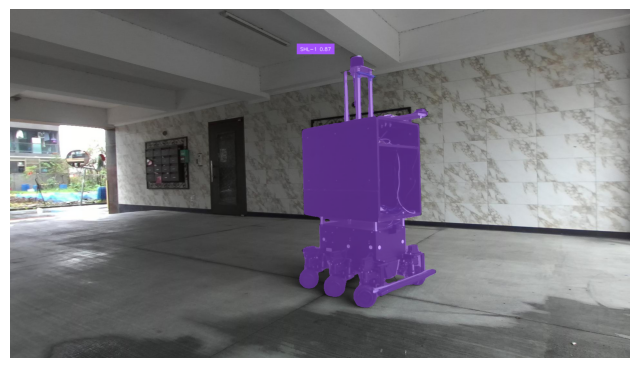

time: 399 ms (started: 2024-12-18 11:10:21 +00:00)


In [ ]:
plot(
    image=cv2.imread("/content/dataset/valid/images/image_00401.jpg"),
    classes=base_model.ontology.classes(),
    detections=results
)

### Fine-tuned model

In [ ]:
pred = target_model_n.predict("/content/dataset/valid/images/image_00401.jpg")


image 1/1 /content/dataset/valid/images/image_00401.jpg: 384x640 1 SHL-1, 107.8ms
Speed: 2.5ms preprocess, 107.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
time: 990 ms (started: 2024-12-18 13:16:16 +00:00)


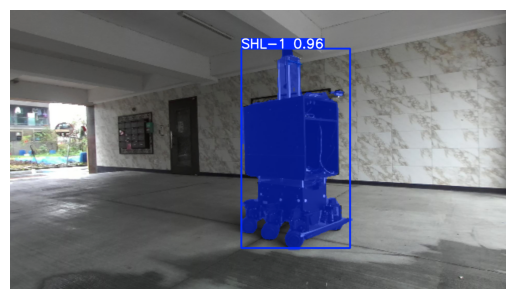

time: 371 ms (started: 2024-12-18 13:16:23 +00:00)


In [ ]:
annotated = pred[0].plot()

# Convert BGR to RGB for matplotlib
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(annotated_rgb)
plt.axis('off')  # Hide axes
plt.show()

## Download best model

In [ ]:
# Download the best model
from google.colab import files
files.download('/content/runs/segment/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 30.7 ms (started: 2024-12-18 13:11:33 +00:00)
